# PCB Thermography Analysis Program
### Objective
This program is designed to process PCB thermography images (both radiometric `.tif` and non-radiometric `.jpg`/`.png` formats). The workflow involves:
1. Loading and displaying the thermography image.
2. Selecting and centering the PCB by defining the corners.
3. Defining emissivity shapes (circles, quadrilaterals).
4. Calibrating the image based on emissivity and temperature data.

The program adapts to both `.tif` (radiometric) images and non-radiometric RGB images (`.jpg`, `.png`).

---


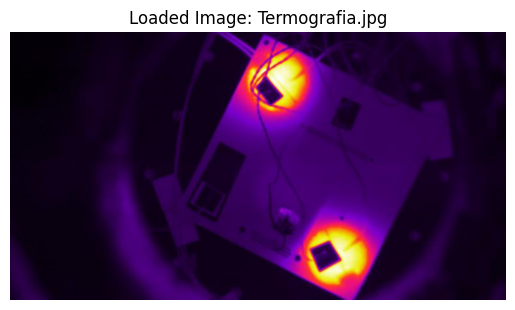

Image Termografia.jpg loaded and displayed successfully.


In [1]:
# Import necessary modules and functions
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

# Import the image processing module
from image_processing import load_and_display_image, select_corners_jpg, select_corners_tif
import emissivity_processing as ep
import calibration_processing as cp


# Ask the user for the image file name (including extension)
image_name = input("Please enter the image name with extension (e.g., image.jpg or image.tif): ")

# Call the function to load and display the image
image = load_and_display_image(image_name)

# Check if the image was successfully loaded
if image is not None:
    print(f"Image {image_name} loaded and displayed successfully.")
else:
    print(f"Failed to load the image {image_name}.")


Seleccione 4 esquinas del PCB haciendo clic en la imagen.
Esquinas seleccionadas: [(431, 3), (728, 160), (574, 447), (282, 299)]


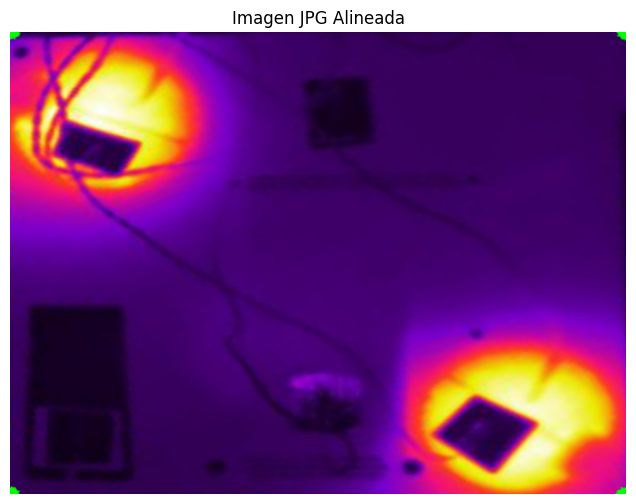

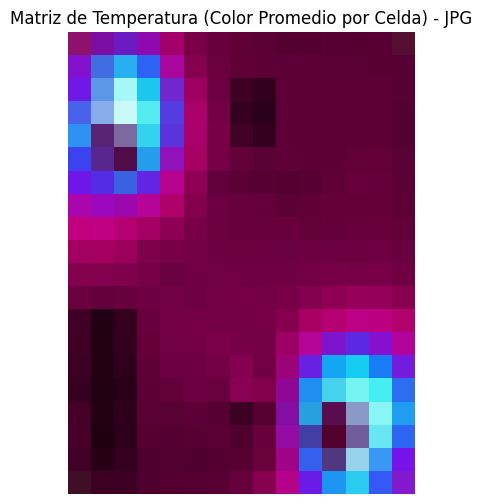

Tramo de la matriz RGB de la imagen JPG:
[[[142.14484127  18.55952381 107.79464286]
  [124.12403101  14.22383721 164.19864341]
  [108.33527132  26.37306202 193.58817829]
  [142.60218254   9.75595238 174.14880952]
  [162.81395349   1.91957364 105.60658915]]

 [[132.23809524  17.64583333 206.16765873]
  [ 64.00581395 109.65794574 225.26453488]
  [ 40.35077519 175.15310078 239.42248062]
  [ 45.49107143  99.86706349 242.24603175]
  [169.42054264   6.32364341 156.45155039]]

 [[112.30555556  25.72718254 230.34325397]
  [ 92.90794574 151.1744186  233.27810078]
  [165.71124031 247.03294574 248.0755814 ]
  [ 27.14583333 199.80456349 239.92956349]
  [113.13662791  38.87596899 206.52325581]]

 [[ 73.77083333  98.38988095 236.0734127 ]
  [136.94767442 171.96317829 234.93895349]
  [201.6753876  250.23546512 249.96608527]
  [ 82.48015873 236.81746032 241.71428571]
  [ 84.02616279  60.43217054 224.0746124 ]]

 [[ 47.44047619 146.67261905 240.38293651]
  [ 90.71705426  36.60949612 117.07170543]
  [12

In [2]:
# Definir la ruta completa de la imagen
image_path = os.path.join("Images", image_name)

# Comprobar la extensión de la imagen (.jpg/.png o .tif)
extension = image_name.split('.')[-1].lower()

# Bandera para saber si estamos procesando un .tif
is_tif = False

if extension in ['jpg', 'png']:
    # Si es .jpg o .png, seleccionar esquinas, alinear la imagen y calcular la matriz de temperatura RGB
    aligned_image_jpg, temperature_matrix_jpg, corners = select_corners_jpg(cv2.imread(image_path))
    
    # print("Imagen .jpg/.png alineada y transformada.")
    # plt.imshow(cv2.cvtColor(aligned_image_jpg, cv2.COLOR_BGR2RGB))
    # plt.title("Imagen Alineada")
    # plt.axis('off')
    # plt.show()

    # Imprimir un tramo de la matriz RGB para asegurar que no está en escala de grises
    print("Tramo de la matriz RGB de la imagen JPG:")
    print(temperature_matrix_jpg[:5, :5, :])  # Imprimir los primeros 5x5 elementos de la matriz RGB

elif extension == 'tif':
    # Si es .tif, activar la bandera para evitar el procesamiento RGB
    is_tif = True

    # Generar un .jpg temporal para la selección de esquinas
    temp_jpg_path = "Images/temp_image.jpg"
    aligned_visual_tif, aligned_radiometric_data = select_corners_tif(image_path, cv2.imread(image_path, cv2.IMREAD_UNCHANGED), temp_jpg_path)

    print("Imagen .tif alineada y transformada.")

    # Mostrar el heatmap de los datos radiométricos
    plt.imshow(aligned_radiometric_data, cmap='hot')
    plt.colorbar(label="Temperatura (Escala relativa)")
    plt.title("Heatmap de los Datos Radiométricos Alineados")
    plt.axis('off')
    plt.show()

else:
    print("Formato de archivo no soportado. Solo se soportan archivos .jpg, .png y .tif.")

Please click on 4 points to define the polygon.
Please click on 4 points to define the polygon.


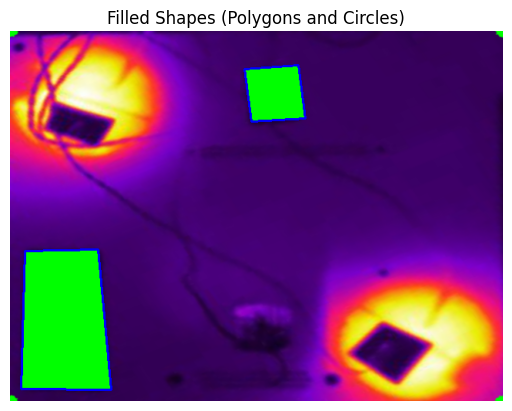

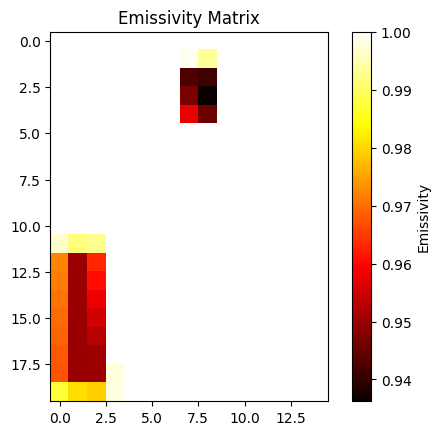


Emissivity information for defined shapes:
Polygon 1: Emissivity = 0.95
Polygon 2: Emissivity = 0.93


In [3]:
base_emissivity = float(input("Enter the base emissivity value for the PCB: "))

# Pass the correct image based on the extension
if extension in ['jpg', 'png']:
    emissivity_matrix = ep.process_emissivity(aligned_image_jpg, base_emissivity)
elif extension == 'tif':
    emissivity_matrix = ep.process_emissivity(aligned_visual_tif, base_emissivity)

In [6]:
m, n = 20, 15

if extension == 'jpg':
    # Use the aligned RGB image as the "temperature matrix" for .jpg
    temperature_matrix_jpg = temperature_matrix_jpg  # Already generated during image processing
    calibrated_temperature_matrix = cp.calibrate_temperature('jpg', aligned_image_jpg, temperature_matrix_jpg, emissivity_matrix, m, n)

elif extension == 'tif':
    # No temperature matrix for .tif, use the radiometric data directly
    calibrated_temperature_matrix = cp.calibrate_temperature('tif', aligned_radiometric_data, aligned_radiometric_data, emissivity_matrix, m, n)

# Visualize the temperature matrix
cp.visualize_temperature_matrix(calibrated_temperature_matrix)

Click on a point where you know the temperature.
The known temperature is: 300.0 K at [(76, 331)].


IndexError: index 331 is out of bounds for axis 0 with size 20